# Analyzing
#### Levi Lutz

In [471]:
from datetime import datetime

import country_converter as coco
import numpy as np
import pandas as pd
import plotnine as pn
import xarray as xr

# Getting Data

Price data sourced from the IMF's [Commodity Price Dataset](https://www.imf.org/en/Research/commodity-prices) (accessed May 10, 2020)

In [464]:
price_table = pd.read_excel("Prices.xlsx")
# Fix table
price_table.drop([0, 1, 2], inplace=True)  # Description rows
price_table["dtime"] = pd.to_datetime(price_table["Commodity"], format="%YM%m")
price_table.drop("Commodity", axis=1, inplace=True)  # Old dates
price_table.set_index("dtime", inplace=True)
price_table = price_table[datetime(1991, 1, 1) : datetime(2019, 12, 1)]

Export data sourced from the ICO's [Historical Data](http://www.ico.org/new_historical.asp) (accessed May 10, 2020)

In [226]:
def exports_dtime(cropyear):
    """Turn crop year format from exports into year."""
    return pd.to_datetime(cropyear.split("/")[-1], format="%y").year

cc = coco.CountryConverter()
def to_country(country_name):
    """Turn country name into ISO3 country code."""
    return cc.convert(country_name, to="ISO3")

In [247]:
exports_table = pd.read_excel("Exports.xlsx", header=3)
# Fix table
exports_table = exports_table[exports_table["Unnamed: 1"].notna()]  # Get rid of grouped data
exports_table.drop("Unnamed: 1", axis=1, inplace=True)
exports_table["country"] = exports_table["Crop year"].apply(to_country)
exports_table = exports_table.set_index("country")
exports_table = exports_table.drop("Crop year", axis=1).transpose()
exports_table.reset_index(inplace=True)
exports_table["year"] = exports_table["index"].apply(exports_dtime)
exports_table.set_index("year", inplace=True)
exports_table.drop("index", axis=1, inplace=True)

Global temperature data sourced from the NOAA's [NCEI surface temperature analysis](https://www.ncdc.noaa.gov/noaa-merged-land-ocean-global-surface-temperature-analysis-noaaglobaltemp-v5) (accessed May 10, 2020)

In [288]:
temp_table = xr.open_dataset("temperatures.nc").to_dataframe()
temp_table.reset_index(inplace=True)
temp_table["location"] = list(zip(temp_table["lat"], temp_table["lon"]))
temp_table["dtime"] = pd.to_datetime(temp_table["time"], format="%Y-%m-%d")
temp_table = temp_table.pivot(index="location", columns="dtime", values="anom")
mind = pd.MultiIndex.from_tuples(temp_table.reset_index()["location"])
temp_table.set_index(mind, inplace=True)

Country locations sourced from Harvard's [WorldMap resource](https://worldmap.harvard.edu/data/geonode:country_centroids_az8) (accessed May 10, 2020)

In [241]:
centers = pd.read_csv("Country_centers.csv")
centers = centers[["adm0_a3", "Longitude", "Latitude"]]
centers.columns = ["country", "lng", "lat"]

# Combining Data

In [261]:
# Get proportion of all exports from each country
weights = exports_table.copy()
tots = weights.sum(axis=1)
weights = weights.div(tots, axis=0)

In [509]:
# Get temperatures for each country
ctemps = centers.copy()
ctemps["lng"] = ctemps["lng"] % 360  # Correct to 0-360 range
# Round to nearest 5x5 centroid (like temperature map)
ctemps["lat"] = 5 * (ctemps["lat"] // 5) + 2.5
ctemps["lng"] = 5 * (ctemps["lng"] // 5) + 2.5
# Combine longitude and latitude to multiindex
ctemps["location"] = list(zip(ctemps["lat"], ctemps["lng"]))
mind = pd.MultiIndex.from_tuples(ctemps["location"])
ctemps.set_index(mind, inplace=True)
ctemps.drop(["lng", "lat", "location"], axis=1, inplace=True)
# Join with temperature table to get yearly temp anomaly at country center
ctemps = ctemps.join(temp_table).set_index("country")
ctemps = ctemps.transpose()
ctemps = ctemps[datetime(1991, 1, 1) : datetime(2019, 12, 1)]
ctemps = ctemps[weights.columns]
ctemps.reset_index(inplace=True)
ctemps["year"] = ctemps["index"].apply(lambda dt: dt.year)
ctemps.set_index("index", inplace=True)

In [510]:
for time, data in ctemps.iterrows():
    for country, temp in data.items():
        if country is not "year" and not np.isnan(temp):
            ctemps[country][time] = temp * weights[country][data["year"]]
ctemps.drop("year", axis=1, inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [670]:
# Collect temperature and price data into one dataframe
final_temps = ctemps.apply(np.sum, axis=1)
final_prices = pd.to_numeric(price_table["PCOFFOTM"])
tp_dict = {"temp": final_temps, "price": final_prices}
temp_prices = pd.concat(tp_dict, axis=1)

In [710]:
# Make dataframe of temperature and price derivatives
smth = 10
win = 2 * smth + 1
d_temps = final_temps.iloc[1:] - final_temps.iloc[:-1].to_numpy()
d_temps = d_temps.rolling(window=win, win_type="gaussian", center=True).mean(std=smth)[smth:-smth]
d_prices = final_prices.iloc[1:] - final_prices.iloc[:-1].to_numpy()
d_prices = d_prices.rolling(window=win, win_type="gaussian", center=True).mean(std=smth)[smth:-smth]
diff_tp = pd.concat({"temp": d_temps, "price": d_prices}, axis=1)

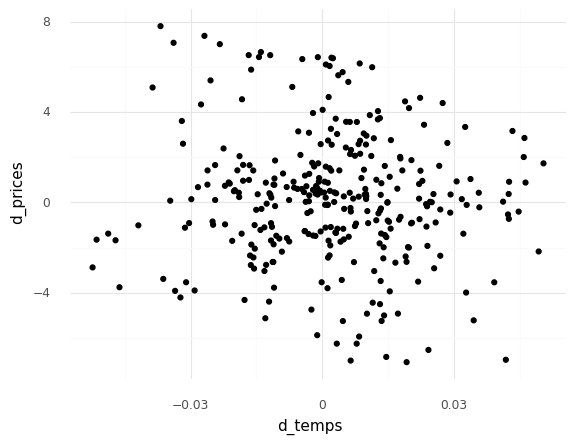

<ggplot: (594673117)>

In [711]:
plot = (
    pn.ggplot(diff_tp, pn.aes(x="d_temps", y="d_prices")) +
    pn.geom_point() +
    pn.theme_minimal()
)
plot

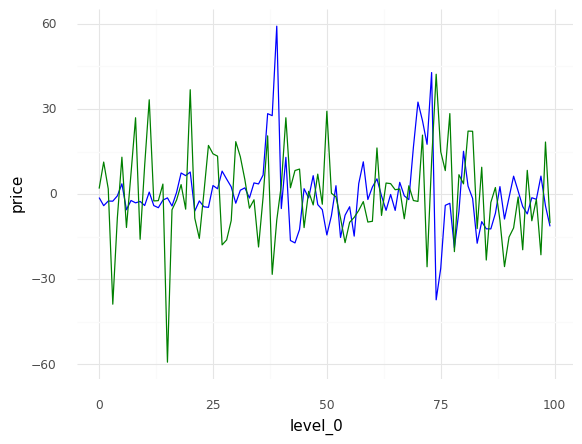

<ggplot: (594949325)>

In [685]:
color1 = "blue"
color2 = "green"
data = diff_tp[0:100]
scale = max(abs(data["price"])) / max(abs(data["temp"]))
data = data.reset_index().reset_index()
plot = (
    pn.ggplot(data, pn.aes(x="level_0")) +
    pn.geom_line(pn.aes(y="price"), color=color1) +
    pn.geom_line(pn.aes(y=data["temp"] * scale), color=color2) +
    pn.theme_minimal()
)
plot

In [607]:
max(temp_prices["price"])

302.7094736842105